## 1. 필요한 패키지들 불러오기

In [1]:
from sklearn.datasets import load_digits, load_wine, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Digit dataset

## 2. 데이터 준비

In [2]:
digits = load_digits()

## 3. 데이터 이해하기

In [3]:
target_names = digits["target_names"]
feature_names = digits["feature_names"]
desc = digits["DESCR"]

print(f"종속변수 카테고리 종류 : {target_names}")
print(f"독립변수 : {feature_names}")
print("\n")
print(desc)

종속변수 카테고리 종류 : [0 1 2 3 4 5 6 7 8 9]
독립변수 : ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']


.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

In [4]:
x_digits, y_digits = load_digits(return_X_y=True)

유명한 손글씨 이미지 데이터셋의 카테고리 종류와 카테고리별 데이터의 개수를 막대그래프로 표현하겠습니다.

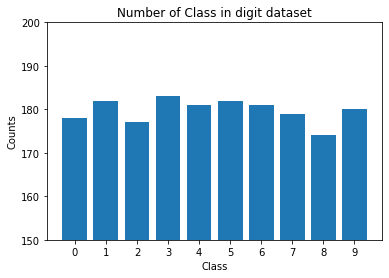

In [5]:
digit_class, digit_counts = np.unique(y_digits, return_counts=True)
plt.bar(digit_class, digit_counts)
plt.xticks(digit_class)
plt.title("Number of Class in digit dataset")
plt.ylim(150, 200)
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

시각화를 한 결과 전체적으로 고루 분포하다는 것을 알 수가 있었고, 카테고리 8의 데이터 개수가 가장 적었으며 카테고리 3의 데이터 개수가 가장 많다는 것을 알 수 있었습니다.

In [6]:
print(f"데이터 개수 : {x_digits.shape[0]}\n칼럼 개수 : {x_digits.shape[1]}")

데이터 개수 : 1797
칼럼 개수 : 64


칼럼 개수가 64개라는 의미는 해당 데이터셋은 8 x 8 크기의 이미지 데이터라는 뜻으로 일부 데이터를 시각화하여 해당 이미지 데이터는 어떻게 생겼는지 확인하겠습니다.

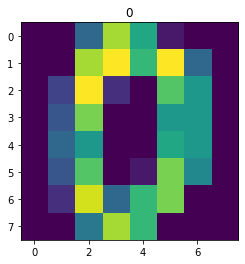

In [7]:
plt.imshow(x_digits[0].reshape(8,8))
plt.title(y_digits[0])
plt.show()

## 4. train, test 데이터 분리

전체 데이터셋을 모델의 학습에 활용될 훈련 데이터셋과 학습이 완료된 데이터를 테스트하는 목적의 테스트 데이터셋을 8:2의 비율로 나누겠습니다.

In [8]:
x_train_dg, x_test_dg, y_train_dg, y_test_dg = train_test_split(x_digits, 
                                                                y_digits,
                                                                test_size = 0.2,
                                                                random_state = 1)

전체 데이터셋을 훈련 데이터셋과 테스트 데이터셋으로 나눈 결과 훈련 데이터셋의 개수는 1437개이고, 테스트 데이터셋의 개수는 360개가 나왔습니다.

In [9]:
print(f"훈련 데이터 개수 : {x_train_dg.shape[0]}\n테스트 데이터 개수 : {x_test_dg.shape[0]}")

훈련 데이터 개수 : 1437
테스트 데이터 개수 : 360


## 5. 다양한 모델로 학습시켜보기

훈련 데이터셋의 전처리부터 모델 적합까지의 과정을 담은 파이프라인을 설계하겠습니다.  
1. 전처리 과정에서는 Min-Max-Scaling을 적용하여 전체 값들의 범위를 0에서 1사이의 값으로 스케일링을 하겠습니다.
2. 스케일링이 완료된 데이터는 GridSearchCV 에 담겨져 있는 모델의 입력값으로 들어갑니다.
3. 사용된 모델은 다음과 같습니다.
    - LogisticRegression()
    - RandomForest()
    - GradientBoosting()
    - DecisionTreeClassifier()
    - SGDClassifier()
    - SVC()
    - KNN()
    - MultinomialNB()
4. 각 모델마다 3-fold 교차 검증을 적용하며 **종속변수의 각 범주별 데이터 개수가 170개 이상으로 비등하기에** 모델의 성능 척도는 **accuracy**로 선택합니다
5. 각 모델과 파라미터에서 가장 좋은 성능을 가진 모델과 파라미터를 반환합니다.

In [11]:
pipeline = Pipeline([
    ('transformer', MinMaxScaler()),
    ('model', 'passthrough')
])
params = [
    {'model': (LogisticRegression(),),
     'model__max_iter' : (300, 400)},
    
    {'model':(RandomForestClassifier(),),
     'model__n_estimators' : (150, 200)},
    
    {'model':(GradientBoostingClassifier(),),
     'model__n_estimators' : (150, 200)},
    
    {'model':(DecisionTreeClassifier(),)},
    
    {'model':(SGDClassifier(),)},
    
    {'model':(SVC(),)},
    
    {'model':(KNeighborsClassifier(),)},
    
    {'model':(MultinomialNB(),)}
]
digit_model = GridSearchCV(pipeline, params, scoring='accuracy', 
                           verbose = 3,
                           cv = 3,
                           n_jobs = 4
                          )
digit_model.fit(x_train_dg, y_train_dg)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done  33 out of  33 | elapsed:   29.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer', MinMaxScaler()),
                                       ('model', 'passthrough')]),
             n_jobs=4,
             param_grid=[{'model': (LogisticRegression(),),
                          'model__max_iter': (300, 400)},
                         {'model': (RandomForestClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (GradientBoostingClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (DecisionTreeClassifier(),)},
                         {'model': (SGDClassifier(),)}, {'model': (SVC(),)},
                         {'model': (KNeighborsClassifier(),)},
                         {'model': (MultinomialNB(),)}],
             scoring='accuracy', verbose=3)

GridSearchCV 의 3 - fold 검증 결과들을 정리해서 보여줍니다.

In [12]:
digit_model.cv_results_

{'mean_fit_time': array([4.33990399e-01, 4.42355394e-01, 8.89164607e-01, 1.17854532e+00,
        1.45416350e+01, 1.39667765e+01, 2.63940493e-02, 7.15131760e-02,
        1.03337685e-01, 1.62775517e-02, 3.26188405e-03]),
 'std_fit_time': array([1.85192237e-02, 3.25471702e-02, 2.71265077e-02, 1.52036593e-02,
        2.62421855e-01, 2.88452593e+00, 1.15176340e-02, 1.43171349e-02,
        3.24637571e-03, 9.46254630e-03, 1.79136233e-04]),
 'mean_score_time': array([0.00113169, 0.00114735, 0.05263813, 0.07895096, 0.04014389,
        0.02092385, 0.00121204, 0.00125035, 0.05584669, 0.14759191,
        0.00104793]),
 'std_score_time': array([5.10257846e-05, 6.75950193e-05, 7.55007107e-03, 1.29950271e-02,
        1.19321536e-02, 1.15082025e-04, 1.30715775e-04, 3.19672601e-05,
        1.03307880e-02, 9.16680811e-03, 8.93238175e-05]),
 'param_model': masked_array(data=[LogisticRegression(), LogisticRegression(),
                    RandomForestClassifier(), RandomForestClassifier(),
               

최적의 파라미터를 가진 모델은 SVC()로 나왔습니다.

In [13]:
digit_model.best_params_

{'model': SVC()}

각 모델별 성능 순위를 보여줍니다. 순서는 params 에서 지정되어 진행되는 모델들의 순서입니다.

In [14]:
digit_model.cv_results_["rank_test_score"]

array([ 5,  5,  3,  4,  8,  7, 11,  9,  1,  2, 10], dtype=int32)

각 모델들의 3 - fold 에서 나온 검증 정확도들의 평균을 나타냅니다.

In [15]:
digit_model.cv_results_["mean_test_score"]

array([0.95685456, 0.95685456, 0.96798887, 0.96729297, 0.9512874 ,
       0.95476688, 0.81558803, 0.94363257, 0.98329854, 0.97355602,
       0.89422408])

GridSearchCV 모델들을 적합한 결과 가장 좋은 성능을 낸 모델과 파라미터, 전처리 조건을 출력합니다.

In [16]:
digit_model.best_estimator_

Pipeline(steps=[('transformer', MinMaxScaler()), ('model', SVC())])

검증 점수가 가장 높을 때의 결과를 출력합니다

In [17]:
digit_model.best_score_

0.9832985386221295

GridSearchCV 로 반환된 최적의 모델로 테스트셋을 추론하고 추론하여 나온 예측값과 실제값과 비교하여 나온 정확도를 반환합니다.

In [18]:
# best_estimator 기준 결과 반환
digit_model.score(x_test_dg, y_test_dg)

0.9916666666666667

## 6. 결론

SVC모델을 기준으로 테스트셋을 분류한 accuracy는 약 99%가 나왔습니다.

# Wine dataset

## 2. 데이터 준비

In [20]:
wine = load_wine()

## 3. 데이터 이해하기

In [21]:
target_names = wine["target_names"]
feature_names = wine["feature_names"]
desc = wine["DESCR"]

print(f"종속변수 카테고리 종류 : {target_names}")
print(f"독립변수 : {feature_names}")
print("\n")
print(desc)

종속변수 카테고리 종류 : ['class_0' 'class_1' 'class_2']
독립변수 : ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    =

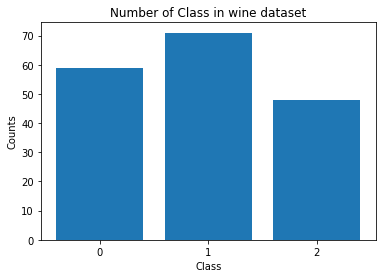

In [25]:
wine_class, wine_counts = np.unique(y_wine, return_counts=True)
plt.bar(wine_class, wine_counts)
plt.xticks(wine_class)
plt.title("Number of Class in wine dataset")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

In [24]:
x_wine, y_wine = load_wine(return_X_y=True)

In [26]:
x_wine.shape

(178, 13)

In [27]:
x_wine[0]

array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
       3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
       1.065e+03])

## 4. train, test 데이터 분리

In [28]:
x_train_wn, x_test_wn, y_train_wn, y_test_wn = train_test_split(x_wine, 
                                                                y_wine,
                                                                test_size = 0.2,
                                                                random_state = 2)

## 5. 다양한 모델로 학습시켜보기

In [29]:
wine_model = GridSearchCV(pipeline, params, scoring='accuracy', 
                     return_train_score=True)
wine_model.fit(x_train_wn, y_train_wn)

GridSearchCV(estimator=Pipeline(steps=[('transformer', MinMaxScaler()),
                                       ('model', 'passthrough')]),
             param_grid=[{'model': (LogisticRegression(),),
                          'model__max_iter': (300, 400)},
                         {'model': (RandomForestClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (GradientBoostingClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (DecisionTreeClassifier(),)},
                         {'model': (SGDClassifier(),)}, {'model': (SVC(),)},
                         {'model': (KNeighborsClassifier(),)},
                         {'model': (MultinomialNB(),)}],
             return_train_score=True, scoring='accuracy')

In [32]:
wine_model.best_estimator_

Pipeline(steps=[('transformer', MinMaxScaler()), ('model', SVC())])

In [33]:
wine_model.best_score_

0.9928571428571429

In [34]:
wine_model.score(x_test_wn, y_test_wn)

0.9722222222222222

## 6. 결론

wine dataset의 경우 parameter를 모두 default로 둔 기준으로 SVC모델이 가장 accuracy가 높게 나왔습니다.

SVC모델을 기준으로 testset을 분류한 accuracy는 약 97%가 나왔습니다.

# Cancer dataset

## 2. 데이터 준비

In [44]:
cancer = load_breast_cancer()

## 3. 데이터 이해하기

In [45]:
target_names = cancer["target_names"]
feature_names = cancer["feature_names"]
desc = cancer["DESCR"]

print(f"종속변수 카테고리 종류 : {target_names}")
print(f"독립변수 : {feature_names}")
print("\n")
print(desc)

종속변수 카테고리 종류 : ['malignant' 'benign']
독립변수 : ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation

[212 357]


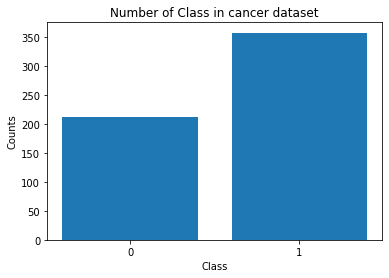

In [46]:
cancer_class, cancer_counts = np.unique(y_cancer, return_counts=True)
print(cancer_counts)
plt.bar(cancer_class, cancer_counts)
plt.xticks(cancer_class)
plt.title("Number of Class in cancer dataset")
plt.ylabel("Counts")
plt.xlabel("Class")
plt.show()

해당 데이터셋은 0인 카테고리가 212개이고, 1인 카테고리가 357개로 다른 데이터셋에 비하여 데이터 불균형 문제가 더 심각하게 보여지고 있습니다.  

In [47]:
x_cancer, y_cancer = load_breast_cancer(return_X_y=True)
x_cancer.shape

(569, 30)

## 4. train, test 데이터 분리

In [48]:
x_train_cc, x_test_cc, y_train_cc, y_test_cc = train_test_split(x_cancer, 
                                                                y_cancer,
                                                                test_size = 0.2,
                                                                random_state = 3)

## 5. 다양한 모델로 학습시켜보기

이전 데이터 이해하기에서 0과 1로 분류되는 데이터의 불균형 문제가 있다는 것을 발견하였습니다.

데이터 불균형이 심한 데이터셋에서는 모델 평가 지표에 대한 고민이 더 필요합니다.   
왜냐하면 예를 들어 정상데이터개 99개이고 비정상 데이터가 1개일 때의 모델은 단순히 모든 데이터를 정상 데이터라고 예측만 해도 모델의 accuracy는 99%로 굉장히 높아보이지만 실제로는 비정상 데이터 1개도 분류하지 못하는 좋지 못한 모델이라는 것 입니다.  

데이터 불균형이 심한 데이터셋은 일반적인 지표인 accuracy를 사용하기 보다는 recall, precision, F1-score와 같은 지표를 사용하여 모델의 성능을 좀 더 신뢰성 있게 평가할 수 있습니다.

3가지 지표중에서 F1-score는 recall과 precision의 조화 평균으로 모델이 어떻게 분류를 하든 객관적이고 신뢰성 있는 점수를 도출해주기에 해당 데이터셋에서의 모델들의 평가지표는 F1-score를 사용하겠습니다.

지표에 대한 이해도를 높이기 위해서 기준 지표가 accuracy일때의 모델과 F1-score일 때의 모델을 비교해보겠습니다.

In [49]:
acc_cancer_model = GridSearchCV(pipeline, params, scoring='accuracy', 
                     return_train_score=True)
acc_cancer_model.fit(x_train_cc, y_train_cc)

GridSearchCV(estimator=Pipeline(steps=[('transformer', MinMaxScaler()),
                                       ('model', 'passthrough')]),
             param_grid=[{'model': (LogisticRegression(),),
                          'model__max_iter': (300, 400)},
                         {'model': (RandomForestClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (GradientBoostingClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (DecisionTreeClassifier(),)},
                         {'model': (SGDClassifier(),)}, {'model': (SVC(),)},
                         {'model': (KNeighborsClassifier(),)},
                         {'model': (MultinomialNB(),)}],
             return_train_score=True, scoring='accuracy')

In [50]:
f1_cancer_model = GridSearchCV(pipeline, params, scoring='f1', 
                     return_train_score=True)
f1_cancer_model.fit(x_train_cc, y_train_cc)

GridSearchCV(estimator=Pipeline(steps=[('transformer', MinMaxScaler()),
                                       ('model', 'passthrough')]),
             param_grid=[{'model': (LogisticRegression(),),
                          'model__max_iter': (300, 400)},
                         {'model': (RandomForestClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (GradientBoostingClassifier(),),
                          'model__n_estimators': (150, 200)},
                         {'model': (DecisionTreeClassifier(),)},
                         {'model': (SGDClassifier(),)}, {'model': (SVC(),)},
                         {'model': (KNeighborsClassifier(),)},
                         {'model': (MultinomialNB(),)}],
             return_train_score=True, scoring='f1')

In [64]:
print(f"최적의 모델 조건 :{acc_cancer_model.best_estimator_}")

print(f"검증셋 평균 점수 : {acc_cancer_model.best_score_}")

print(f"테스트셋 점수 : {acc_cancer_model.score(x_test_cc, y_test_cc)}")

최적의 모델 조건 :Pipeline(steps=[('transformer', MinMaxScaler()), ('model', SVC())])
검증셋 평균 점수 : 0.9758241758241759
테스트셋 점수 : 0.9649122807017544


In [63]:
print(f"최적의 모델 조건 :{f1_cancer_model.best_estimator_}")

print(f"검증셋 평균 점수 : {f1_cancer_model.best_score_}")

print(f"테스트셋 점수 : {f1_cancer_model.score(x_test_cc, y_test_cc)}")

최적의 모델 조건 :Pipeline(steps=[('transformer', MinMaxScaler()), ('model', SGDClassifier())])
검증셋 평균 점수 : 0.9811473813596343
테스트셋 점수 : 0.9589041095890412


## 6. 결론

모델의 성능 지표를 바꾸기만 하였는데도 최적의 모델로 선택된 모델은 서로 다르게 나왔습니다. 
accuracy인 경우 SVC가 최적의 모델로 나왔으며 f1의 경우 SGDClassifier가 최적의 모델로 선택되어졌습니다.

모델의 성능 지표를 accuracy로 하였을 경우 SVC가 최적의 모델로 검증셋의 점수는 약 0.97로 f1일 때보다 낮았지만 테스트셋에서의 점수는 0.96으로 f1일때의 0.95보다 더 높게 나왔습니다.

비록 현재의 모델에서는 테스트셋의 점수가 accuracy일때가 더 높게 나왔지만 해당 점수가 정말로 모델의 성능을 증명해준다고 생각하기에는 데이터 불균형 문제로 인한 의심을 받게 됩니다.

이러한 의심과 걱정을 계속하느니 해당 방법에서 벗어나 좀 더 객관적이고 신뢰성 있는 지표인 F1-score를 사용하는 것이 좋다고 생각합니다.


## 7. 참고사이트
- https://www.python2.net/questions-688254.htm  
- https://stackoverflow.com/questions/34848266/typeerror-if-no-scoring-is-specified-the-estimator-passed-should-have-a-score
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV.score
- https://datascienceschool.net/03%20machine%20learning/14.01%20%EB%AA%A8%ED%98%95%20%EC%B5%9C%EC%A0%81%ED%99%94.html
- https://scikit-learn.org/stable/modules/compose.html#pipeline